In [2]:
import numpy as np
from astropy import units as u
from astropy import constants as cnst
from astropy.coordinates import *
from astropy import table
from astropy.visualization import hist as ahist
from astropy.io import fits
from astropy import convolution
import os
from astropy.table import QTable, Table
from astropy import units as u
from astropy.coordinates import SkyCoord
#import spectro as spec
#from IGM import rb_iter_contfit as r
from astropy.cosmology import Planck13 as cosmo
from matplotlib.patches import Ellipse

import pickle
#import CosSaga as cs

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import rcParams, rc
from matplotlib.ticker import MaxNLocator

rc ('xtick',labelsize=13)
rc ('ytick',labelsize=13)
rc('font',family='serif', size=18)
rcParams['axes.linewidth'] = 1.5
rcParams['image.interpolation'] = 'none'
rcParams['figure.figsize'] = (24, 36)


In [4]:
red='#c9002f'

In [5]:
os.remove(saga.database["host_stats"].local.path)
saga.database["host_stats"].clear_cache()

NameError: name 'saga' is not defined

In [ ]:
import SAGA
print(SAGA.__version__)
saga = SAGA.QuickStart(local_dir="/Users/ahamanowicz/Desktop/COS-SAGA/notebooks")
hosts = saga.host_catalog.load(include_stats=True)
assert saga.good.count(hosts) == 134
assert saga.paper3.count(hosts) == 100
assert saga.paper3.filter(hosts, "sats_total").sum() == 351

In [ ]:
saga.database["combined_base"].remote.path = "https://rutgers.box.com/shared/static/0ql9oqqhzu2wt3gwiwn84etzrejobsms.fits"

In [ ]:
paper3_hosts = saga.host_catalog.load(query="paper3", include_stats=True)
#base=saga.database["combined_base"].download(overwrite=True)
base = saga.object_catalog.load_combined_base_catalog()
# base = saga.host_catalog.construct_host_query("paper3").filter(base)

In [ ]:
from SAGA import ObjectCuts as C
hosts = saga.host_catalog.load(query="paper3",include_stats=True)
base = saga.object_catalog.load_combined_base_catalog()
base = saga.host_catalog.construct_host_query("paper3").filter(base)
sats = C.is_sat.filter(base)

In [ ]:
LP=range(1,11)
qso_list=['TON1129','J0958+3224','J0959+3203','J1202-0129','J1202+0225','SBS1421+511','J1429+0321','J1431+0301','J1451+5914', 'J1700+2237']
orig_name=['TON1129','FBQSJ095820.9+322402','SDSSJ095914.85+320357.2','2MASXJ12022678-0129155','SDSSJ120233.08+022559.7','SBS1421+511','SDSSJ142940.73+032125.8','SDSSJ143145.99+030143.8','2MASXJ14515156+5914001','UVQSJ170043.71+223700.2']
host_haloid = [85746,85746,85746,140594,13927,144953,165082,165082,165707,147606]
hostID=['nsa85746', 'nsa85746','nsa85746','nsa140594','nsa13927','nsa144953', 'nsa165082','nsa165153','nsa165707','nsa147606']
z_qso=np.array([0.52611, 0.53060,0.56462,0.15069,0.27364,0.27622,0.25344,0.34055,0.29668,0.445132])
host_helio_vel=[1457.0,1457.0,1457.0, 1461.8, 1967.7,2221. ,1657.4,1657.4,2148.21,2795.2 ]
impact_param_host=[209.222285927, 13.4803426516, 157.119171001, 260.98587288, 235.973508037, 268.169740606,53.8712889489,244.117128625,155.099676124,271.80888]
raqso=[149.0967254638672, 149.58726501464844, 149.81187438964844, 180.6114959716797,180.6378631591797, 215.80909729003906, 217.41976928710938, 217.94163513183594,222.96473693847656,255.182125]
decqso=[32.60601806640625, 32.4006233215332, 32.06591033935547,-1.487576961517334,2.4332659244537354, 50.927024841308594, 3.3571879863739014, 3.028848886489868, 59.23335647583008, 22.616722222222222]
redshift = np.round(np.array(host_helio_vel)/3.e5, 5)
host_distance=[25.004747,25.004747,25.004747,23.120869, 0,34.035793,24.785791,24.785791, 33.376366,39.315384 ]

sightlines_table=Table([qso_list, orig_name, host_haloid,host_helio_vel, redshift, impact_param_host, host_distance, raqso,decqso], names=("sightline", "QSO_name", "NAID", "host_helio_vel", "host_z", "b_host", "host distance", "RA QSO", "DEC QSO"))
sightlines_table.show_in_notebook()




In [6]:
#Metal absorption lines + Ly alpha selection from Leehnrer+18 for the COS wavelength range

lines = ['N I 1134','Fe II 1144','Si II 1190','S III 1190', 'Si II 1193','N I 1200','Si III 1206', 'HI 1215',  'NV 1238', 'NV 1242','S II 1250', 'S II 1253','S II 1258','Si II 1260',
         'OI 1302',  'Si II 1304','CII 1334',    'Si IV 1393',
         'Si IV 1402',
         'Si II 1526']
lines_wav =[1215.6700,1302.1685, 1334.5323,1200.66, 1134.66, 1238.8210,1242.8040, 1260.4221, 1193.2897, 1190.4158, 1526.7070, 1304.3702, 1206.5000, 1393.7602, 1402.729, 1144.9379, 1259.5180, 1253.8050, 1250.5780,1190.2030 ] 
lines_wav = sorted(lines_wav)
#osc_strength=[2.70, 1.80, 2.23, 2.20,2.02,1.71, 1.67, 1.51, 1.22, 2.29, 1.98, 3.17, 2.84, 2.54, 2.31, 2.05, 3.29, 2.85, 2.55, 1.98, 1.79, 1.32, 1.14, 0.83, 1.45]
lp=range(1,np.size(lines)+1)
lines_table=Table([lp,lines,lines_wav], names=("Lp","Species", 'Wavelength'))
lines_table.pprint_all()

# line list from Rongmon
line_list_dir='/Users/ahamanowicz/Documents/GitHub/rbcodes/IGM/lines/lls.lst'
line_list=np.loadtxt(line_list_dir, skiprows=1, dtype='str')


 Lp   Species   Wavelength
--- ----------- ----------
  1    N I 1134    1134.66
  2  Fe II 1144  1144.9379
  3  Si II 1190   1190.203
  4  S III 1190  1190.4158
  5  Si II 1193  1193.2897
  6    N I 1200    1200.66
  7 Si III 1206     1206.5
  8     HI 1215    1215.67
  9     NV 1238   1238.821
 10     NV 1242   1242.804
 11   S II 1250   1250.578
 12   S II 1253   1253.805
 13   S II 1258   1259.518
 14  Si II 1260  1260.4221
 15     OI 1302  1302.1685
 16  Si II 1304  1304.3702
 17    CII 1334  1334.5323
 18  Si IV 1393  1393.7602
 19  Si IV 1402   1402.729
 20  Si II 1526   1526.707


OSError: /Users/ahamanowicz/Documents/GitHub/rbcodes/IGM/lines/lls.lst not found.

## SAGA hosts and satellites information


In [7]:
## HOSTS
N=np.size(hosts['NSAID'])

cos_saga_hosts = Table(names=('HOSTID', 'RA', 'DEC', 'V_HELIO', 'M_HALO'), dtype=('int', 'float','float','float','float'))

#print(hosts.colnames)
for n in range(N):
    for hostid in sightlines_table['NAID']:
        if hosts['NSAID'][n] == hostid:
            if hostid not in cos_saga_hosts['HOSTID']:
            # print(hostid, hosts['RA'][n],hosts['DEC'][n], hosts['V_HELIO'][n], hosts['M_HALO'][n])
                cos_saga_hosts.add_row([int(hostid), hosts['RA'][n],hosts['DEC'][n], hosts['V_HELIO'][n], hosts['M_HALO'][n]])
print(cos_saga_hosts)



NameError: name 'hosts' is not defined

Multiple sightlines hosts - 85746

In [8]:
## SATELLITES
#print(sats.colnames)
cos_saga_satellites = Table(names=('HOSTID', 'SATELLITE_ID','RA', 'DEC', 'RHOST_KPC', 'log_sm', 'SPEC_Z'), dtype=('int', 'int', 'float','float','float','float','float'))

M = np.size(sats['OBJID'])
for n in range(M):
    for hostid in sightlines_table['NAID']:
        if sats['HOST_NSAID'][n] == hostid:
            if sats['OBJID'][n] not in cos_saga_satellites['SATELLITE_ID']:
                #print(hostid, sats['OBJID'][n], sats['RA'][n], sats['DEC'][n], sats['RHOST_KPC'][n], sats['log_sm'][n], sats['SPEC_Z'][n])
                cos_saga_satellites.add_row([hostid, sats['OBJID'][n], sats['RA'][n], sats['DEC'][n], sats['RHOST_KPC'][n], sats['log_sm'][n], sats['SPEC_Z'][n]])

                
             
                
                
                
cos_saga_satellites.show_in_notebook()


NameError: name 'sats' is not defined

In [ ]:
cos_saga_satellites.add_row([165082, 681656, 217.67292879868697, 3.425723527320057,137.9065,8.860233342091073, 0.0059271315 ])   
cos_saga_satellites.add_row([165082, 87370, 217.23277401294135, 3.8515685760734075, 279.18707, 8.005020194466411,0.005619451])
cos_saga_satellites.add_row([165082, 74043, 217.33157059631858, 2.7105423683853176, 229.23521 , 8.334861935794631, 0.006001042] )  
cos_saga_satellites.add_row([165082, 1237654879127601248, 217.6812817843503, 3.345383258372323, 123.48099, 7.8975840449981245, 0.0050901882])
cos_saga_satellites.add_row([165082, 631861, 217.86348991150788, 3.0091635379966744, 215.19458, 9.63013231925916, 0.004853365])
cos_saga_satellites.add_row([165082, 87294, 217.9707567106337, 3.3800403176706824, 246.88214, 7.383959234075788, 0.0051894514])
cos_saga_satellites.add_row([165082, 87358, 217.5077014008536, 3.77290518411652, 236.57875,8.94070299945183, 0.0058014514])
cos_saga_satellites.add_row([165082, 681515, 217.26621891520384, 3.1489905554887674, 75.15012,   8.948841647210525, 0.0061711045]  )                 
cos_saga_satellites.add_row([165082, 87290, 217.81893353616692, 3.2567384880858876, 173.30058, 8.521095878865554,  0.005128451] )                          
cos_saga_satellites.add_row([165082, 87352, 217.41257161258602, 3.266285795439988, 14.491487,9.78914648463536, 0.005505524])
cos_saga_satellites.add_row([165082, 1237654879127535715, 217.5043704367497, 3.2208507301408034, 37.550877, 8.739737561710125, 0.0061642644])
cos_saga_satellites.add_row([165082, 87346, 217.70061004360554, 3.796388769547217, 272.6854, 7.503755991290589, 0.005596543]   )                         
                                              
                             

In [9]:
cos_saga_satellites['HOSTID','SATELLITE_ID', 'RA', 'DEC'].show_in_notebook()



idx,HOSTID,SATELLITE_ID,RA,DEC


In [10]:
cos_saga_hosts['No SATELLITES'] = [0,-99,5,9,12,3,1]
cos_saga_hosts.show_in_notebook()
print(cos_saga_hosts)



NameError: name 'cos_saga_hosts' is not defined

ValueError: `bins` must be positive, when an integer

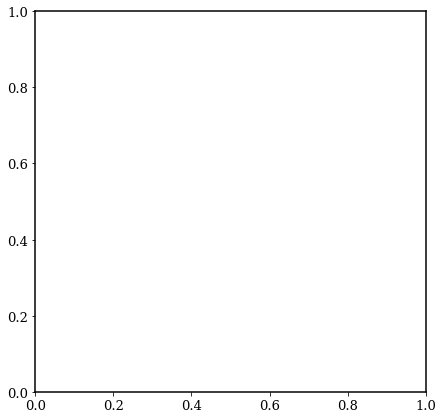

In [11]:
fig=plt.figure(figsize=(7,7))
bins=np.ceil(np.sqrt(np.size(cos_saga_satellites['log_sm'])))
plt.hist(cos_saga_satellites['log_sm'] ,color='navy', lw=4, bins=int(bins), histtype='step', hatch='///')
plt.xlabel(r"Satellite log(M$_*$)")
plt.ylabel(r"N$_{counts}$")
fig.savefig("satellite-stellar-mass.png")

In [ ]:
fig2=plt.figure(figsize=(7,7))
bins_s=np.ceil(np.sqrt(np.size(cos_saga_satellites['RHOST_KPC'])))
bins_h=np.ceil(np.sqrt(np.size(sightlines_table['b_host'])))
plt.hist(cos_saga_satellites['RHOST_KPC'], bins=int(bins_s), color='navy', histtype='step', lw=5, hatch='//',label='satellites')
plt.hist(sightlines_table['b_host'], bins=int(bins_h), color=red, histtype='step', lw=5, hatch='//', label='hosts')
plt.xlabel("Impact parameter from QSO [kpc]")
plt.ylabel(r"N$_{counts}$")
plt.legend(loc=2, fontsize=16)
fig2.savefig("impact-param.png")

## new QSO 


In [12]:
from astropy.io import ascii
data = ascii.read("new-QSO/observed-sept.txt") 
newqso = Table(data)

FileNotFoundError: [Errno 2] No such file or directory: 'new-QSO/observed-sept.txt'

In [13]:
newqso.show_in_notebook()

NameError: name 'newqso' is not defined

In [14]:
from astropy.cosmology import Planck15 as cosmo

In [15]:
a=cosmo.kpc_proper_per_arcmin(3) 
a.value

473.40569119056397

In [16]:
angsep = np.zeros(np.size(newqso['name']))
bkpc = np.zeros(np.size(newqso['name']))
pscale=([3.309, 3.139, 3.591,]) #kpc/"
for i in range(np.size(newqso['name'])):
    #print(newqso['SAGA-host'][i])
    n = newqso['SAGA-host'][i]
    j = np.where(hosts['HOSTID'] == n)[0][0]
    coo = SkyCoord(hosts['RA'][j]*u.deg, hosts['DEC'][j]*u.deg)
    co_qso = SkyCoord(newqso['RA'][i]*u.deg,newqso['DEC'][i]*u.deg )
    sep=co_qso.separation(coo)
    z = hosts['Z_COSMO'][j]
    print(z)
    theta=cosmo.kpc_proper_per_arcmin(z)
    print(sep.arcmin, sep.arcmin*theta.value, z, cosmo.kpc_proper_per_arcmin(z))
    angsep[i] = sep.arcmin
    bkpc[i] = sep.arcmin*theta.value

NameError: name 'newqso' is not defined

In [17]:
newqso.add_columns((angsep,bkpc), names=("r_ang_arcmin", "b_kpc") )

NameError: name 'newqso' is not defined

In [18]:
newqso.show_in_notebook()

NameError: name 'newqso' is not defined

In [19]:
plt.figure(figsize=(6,6))
plt.hist(newqso['b_kpc'],  color=red, histtype='step', lw=5, hatch='//', label='hosts')
plt.xlabel("Impact parameter from QSO [kpc]")
plt.ylabel(r"N$_{counts}$")
plt.legend(loc=2, fontsize=16)

NameError: name 'newqso' is not defined

<Figure size 432x432 with 0 Axes>

In [20]:
angsep = np.array([0.])
bkpc = np.array([0.])

for i in range(np.size(newqso['name'])):
    #print(newqso['SAGA-host'][i])
    n = newqso['SAGA-host'][i]
    J = np.where(sats['HOSTID'] == n)[0]
    print(i, J, n )
    for j in J:
        coo = SkyCoord(sats['RA'][j]*u.deg, sats['DEC'][j]*u.deg)
        co_qso = SkyCoord(newqso['RA'][i]*u.deg,newqso['DEC'][i]*u.deg )
        sep=co_qso.separation(coo)
        z = sats['HOST_ZCOSMO'][j]
        print(angsep)
        theta=cosmo.kpc_proper_per_arcmin(z)
        print(sep.arcmin)
        #print(sep.arcmin, sep.arcmin*theta.value, z, cosmo.kpc_proper_per_arcmin(z))
        angsep = np.concatenate((angsep,sep.arcmin))
        bkpc= np.concatenate(bkpc,sep.arcmin*theta.value)
print(bkpc)

NameError: name 'newqso' is not defined

Hosts with satellites:
 - 85746 host 1 satellite
 - 13927 host ?? 
- 140594 host ??
- 144953 host 5 satellites
- 147606 host 9 satellites
- 165082 host ???

- 165707 host 3 satelites


## Absorber identification


In [21]:
directory='/Users/ahamanowicz/Dropbox/COS-SAGA/Targets/'

## Line measurements

In [22]:

hdul=fits.open("/Users/ahamanowicz/Desktop/COS-SAGA/cos-saga-I/85748/fos.fits.gz")
data=hdul[1].data

(-1e-15, 6e-15)

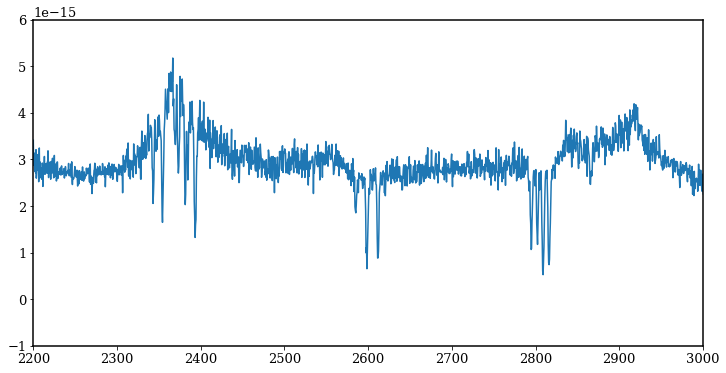

In [23]:
plt.figure(figsize=(12,6))
plt.plot(data['WAVELENGTH'], data['FLUX'])
plt.xlim([2200,3000])
plt.ylim([-1e-15,6e-15])

NameError: name 'sightlines_table' is not defined

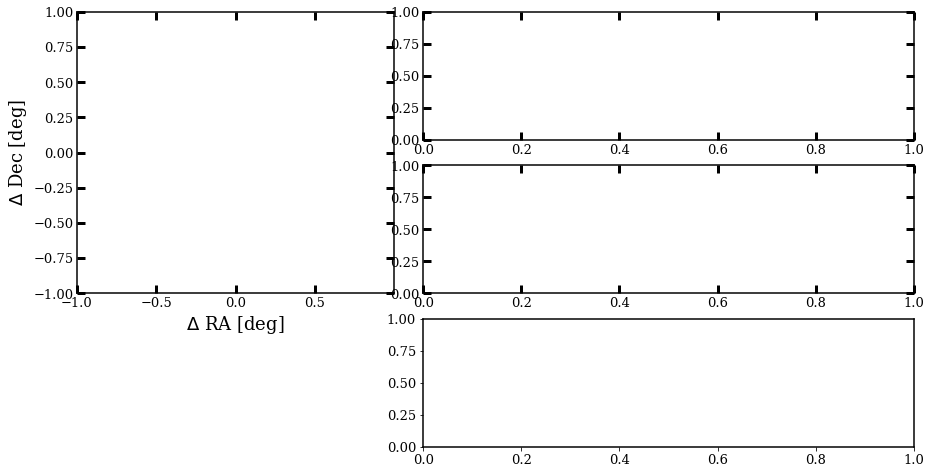

In [24]:
fig = plt.figure(figsize=(15,8))

#ax0 = plt.subplot2grid((3,8), (0, 0), colspan=3, rowspan=1)
ax1 = plt.subplot2grid((3,5), (0, 0), colspan=2, rowspan=2)
ax2 = plt.subplot2grid((3, 5), (0, 2), colspan=3,rowspan=1)
ax3 = plt.subplot2grid((3, 5), (1, 2), colspan=3,rowspan=1)
ax4 = plt.subplot2grid((3, 5), (2, 2), colspan=3,rowspan=1)
# ax5 = plt.subplot2grid((3, 8), (0, 6), colspan=2,rowspan=1)
# ax6 = plt.subplot2grid((3, 8), (1, 6), colspan=2,rowspan=1)
# ax7 = plt.subplot2grid((3, 8), (2, 6), colspan=2,rowspan=1)

velc='#a2798f'
for ax in [ax1,ax2,ax3]:
    ax.tick_params(axis='both', which='major', direction='in', length=8, width=3, bottom=True,top=True,
                  left=True, right=True, reset=True)
    ax.tick_params(axis='both', which='minor', direction='in', length=4, width=3, bottom=True,top=True,
                  left=True, right=True, reset=True)
### skymap
ax1.set_xlim([-1,1])
ax1.set_ylim([-1,1])
ax1.set_xticks([-1,-0.5,0,0.5])
ax1.set_xlabel(r"$\Delta$ RA [deg]")
ax1.set_ylabel(r"$\Delta$ Dec [deg]")

#host coords
hostid=85746
vhost=sightlines_table['host_helio_vel'][0]
host_dist=sightlines_table['host distance'][0]
b_host=[sightlines_table['b_host'][0],sightlines_table['b_host'][1],sightlines_table['b_host'][2]]
cos_saga_hosts.add_index('HOSTID')

m = cos_saga_hosts.loc_indices[hostid]
rahost,dechost=cos_saga_hosts['RA'][m], cos_saga_hosts['DEC'][m]

ax1.scatter(0,0,c='#992959', marker='s', s=150, label='host')
ellipse=(1.86/60*10,0.67/60.*10,105 ) #host orientation
ells=Ellipse(xy=(0,0), width=ellipse[0], height=ellipse[1], angle=ellipse[2]-90, ec='#992959', fc='None')
ax1.add_artist(ells)
#sightlines
draq1,ddecq1 = rahost-sightlines_table['RA QSO'][0], dechost-sightlines_table['DEC QSO'][0]
draq2,ddecq2 = rahost-sightlines_table['RA QSO'][1], dechost-sightlines_table['DEC QSO'][1]
draq3,ddecq3 = rahost-sightlines_table['RA QSO'][2], dechost-sightlines_table['DEC QSO'][2]

ax1.scatter([draq1,draq2,draq3],[ddecq1,ddecq2,ddecq3],c='k', marker='*', s=200)
ax1.plot(-20,-20,c='k', marker='*', ms=20, label='QSO',ls='None' )


#satelites
cos_saga_satellites.add_index('HOSTID')
sat_n = cos_saga_satellites.loc_indices[hostid]

Dras,DDecs,DVs,Bs, Bh=[],[],[],[], []

if np.size(sat_n)>1.:

    for n in sat_n:
        if cos_saga_satellites['HOSTID'][n] == hostid:
            dras,ddecs = rahost-cos_saga_satellites['RA'][n],dechost-cos_saga_satellites['DEC'][n]
            Dras,DDecs=np.append(Dras,dras),np.append(DDecs,ddecs)

else:
    dras,ddecs = rahost-cos_saga_satellites['RA'][sat_n],dechost-cos_saga_satellites['DEC'][sat_n]
    Dras,DDecs=np.append(Dras,dras),np.append(DDecs,ddecs)


ax1.scatter(Dras,DDecs,c='#ffb250', marker='o', s=150, label='satellite')

ax1.legend(fontsize=12)

#spectra & impact param
for s,i,ax in zip(sightlines_table['sightline'][:3], range(3), [ax2,ax3,ax4]): # axi in, [ax5,ax6,ax7]):

    qso_coord = SkyCoord(sightlines_table['RA QSO'][i]*u.deg,sightlines_table['DEC QSO'][i]*u.deg, distance=host_dist*u.Mpc)
    DVs,Bs, Bh=[],[],[]
 
    dvs = (cos_saga_satellites['SPEC_Z'][sat_n]*cnst.c - (vhost)*u.km/u.s).to(u.km/u.s)
    DVs=np.append(DVs,dvs.value)

    #impact parameter to the qso
    sat_coord = SkyCoord(cos_saga_satellites['RA'][sat_n]*u.deg,cos_saga_satellites['DEC'][sat_n]*u.deg,distance=host_dist*u.Mpc)
    sep = qso_coord.separation_3d(sat_coord)
    sep=sep.to(u.kpc)
    bs=sep.value#cos_saga_satellites['RHOST_KPC'][n] 
    Bh = cos_saga_satellites['RHOST_KPC'][sat_n] 
    Bs = np.append(Bs,bs)
      
    #axi.scatter(Bs,DVs,c='#ffb250', marker='o', s=100)
    #ax4.scatter(Bh,DVs,c='#ffb250', marker='o', s=150) 
    
    #axi.scatter(b_host[i],0,c='#992959', marker='s', s=100)
    print(s)
    sline = pickle.load(open("../"+s+'_1215.67.p', 'rb'))
    v=sline.velo
    f=sline.fnorm
    e = sline.enorm -0.6
    ew_er = round(sline.W_e,2)
    N = round(np.log10(sline.logN),2)
    print(N)
    ew = round(sline.W,2)
    ax.annotate('W$_{r}$ = '+ str(ew)+' $\pm$ '+str(ew_er), (0.1,0.8), xycoords='axes fraction', fontsize=15)
    ax.set_xlim([-600,600])
    #axi.set_ylim([-600,600])
    ax.set_ylim([-.6,2.1])
    #axi.set_xlim([-10,350])
    #axi.axhline(0, ls='--', c='gray')
    ax.axvline(0, ls='--',c='#992959')
    ax.axhline(1.0, ls='--', c='gray')
    ax.step(v,f, 'k')
    ax.step(v,e, 'r')

    if np.size(DVs) > 1:
        for dvs in DVs:

            ax.plot([dvs]*2, [1.2,1.5], color='#ffb250', lw=2)
            print(dvs)
    #other absorbers
    else:
        ax.plot([DVs[0]]*2, [1.2,1.5], color='#ffb250', lw=3)
        print(DVs[0])

#ax7.set_xlabel("QSO Impact Parameter [kpc]", fontsize=18)

ax4.set_xlabel("Velocity [km/s]", fontsize=18)
#ax4.set_xlabel("HOST Impact Parameter [kpc]", fontsize=15)



#     ax.set_yticks([0.0, 1.0, 2.0])
# # axs[0].set_xticks(np.arange(-600,600, 50) , minor=True)

# ax2.set_xticks([])
# ax5.set_xticks([])
# ax6.set_xticks([])
# for ax in [ax5,ax6,ax7]:
#     ax.yaxis.tick_right()
#     ax.yaxis.set_label_position("right")
    
# ax6.set_ylabel("$\Delta$ v [km/s]", fontsize=18, rotation=-90)

ax1.annotate('HOST ID: '+str(hostid), xy=(0.1,0.9), xycoords='axes fraction')
fig.savefig("85746-3sightlines.png")

In [ ]:
#proposal version
fig = plt.figure(figsize=(15,8))

#ax0 = plt.subplot2grid((3,8), (0, 0), colspan=3, rowspan=1)
ax1 = plt.subplot2grid((3,5), (0, 0), colspan=2, rowspan=2)
ax2 = plt.subplot2grid((3, 5), (0, 2), colspan=3,rowspan=1)
ax3 = plt.subplot2grid((3, 5), (1, 2), colspan=3,rowspan=1)
ax4 = plt.subplot2grid((3, 5), (2, 2), colspan=3,rowspan=1)
# ax5 = plt.subplot2grid((3, 8), (0, 6), colspan=2,rowspan=1)
# ax6 = plt.subplot2grid((3, 8), (1, 6), colspan=2,rowspan=1)
# ax7 = plt.subplot2grid((3, 8), (2, 6), colspan=2,rowspan=1)

velc='#a2798f'
for ax in [ax2,ax3]:
    ax.tick_params(axis='both', which='major', direction='in', length=8, width=3, bottom=True,top=True,
                  left=True, right=True, reset=True)
    ax.tick_params(axis='both', which='minor', direction='in', length=4, width=3, bottom=True,top=True,
                  left=True, right=True, reset=True)
### skymap
ax1.set_xlim([-1,1])
ax1.set_ylim([-1,1])
ax1.set_xticks([])
ax1.set_yticks([])
# ax1.set_xticks([-1,-0.5,0,0.5])
ax1.set_xlabel(r" RA ")
ax1.set_ylabel(r" Dec ")
#host coords
hostid=85746
vhost=sightlines_table['host velocity (helio)'][0]
host_dist=sightlines_table['Host distance [Mpc]'][0]
b_host=[sightlines_table['impact parameter [kpc]'][0],sightlines_table['impact parameter [kpc]'][1],sightlines_table['impact parameter [kpc]'][2]]
cos_saga_hosts.add_index('HOSTID')

m = cos_saga_hosts.loc_indices[hostid]
rahost,dechost=cos_saga_hosts['RA'][m], cos_saga_hosts['DEC'][m]

ax1.scatter(0,0,c='#992959', marker='s', s=150, label='host')
# ellipse=(1.86/60*10,0.67/60.*10,105 ) #host orientation
# ells=Ellipse(xy=(0,0), width=ellipse[0], height=ellipse[1], angle=ellipse[2]-90, ec='#992959', fc='None')
# ax1.add_artist(ells)
#sightlines
draq1,ddecq1 = rahost-sightlines_table['RA QSO'][0], dechost-sightlines_table['DEC QSO'][0]
draq2,ddecq2 = rahost-sightlines_table['RA QSO'][1], dechost-sightlines_table['DEC QSO'][1]
draq3,ddecq3 = rahost-sightlines_table['RA QSO'][2], dechost-sightlines_table['DEC QSO'][2]

ax1.scatter([draq1,draq2,draq3],[ddecq1,ddecq2,ddecq3],c='k', marker='*', s=200)
ax1.plot(-20,-20,c='k', marker='*', ms=20, label='QSO',ls='None' )


#satelites
cos_saga_satellites.add_index('HOSTID')
sat_n = cos_saga_satellites.loc_indices[hostid]

Dras,DDecs,DVs,Bs, Bh=[],[],[],[], []

if np.size(sat_n)>1.:

    for n in sat_n:
        if cos_saga_satellites['HOSTID'][n] == hostid:
            dras,ddecs = rahost-cos_saga_satellites['RA'][n],dechost-cos_saga_satellites['DEC'][n]
            Dras,DDecs=np.append(Dras,dras),np.append(DDecs,ddecs)

else:
    dras,ddecs = rahost-cos_saga_satellites['RA'][sat_n],dechost-cos_saga_satellites['DEC'][sat_n]
    Dras,DDecs=np.append(Dras,dras),np.append(DDecs,ddecs)


ax1.scatter(Dras,DDecs,c='#ffb250', marker='o', s=150, label='satellite')

ax1.legend(fontsize=12)

#spectra & impact param
for s,i,ax in zip(sightlines_table['QSO'][:3], range(3), [ax2,ax3,ax4]): # axi in, [ax5,ax6,ax7]):

    qso_coord = SkyCoord(sightlines_table['RA QSO'][i]*u.deg,sightlines_table['DEC QSO'][i]*u.deg, distance=host_dist*u.Mpc)
    DVs,Bs, Bh=[],[],[]
 
    dvs = (cos_saga_satellites['SPEC_Z'][sat_n]*cnst.c - (vhost)*u.km/u.s).to(u.km/u.s)
    DVs=np.append(DVs,dvs.value)

    #impact parameter to the qso
    sat_coord = SkyCoord(cos_saga_satellites['RA'][sat_n]*u.deg,cos_saga_satellites['DEC'][sat_n]*u.deg,distance=host_dist*u.Mpc)
    sep = qso_coord.separation_3d(sat_coord)
    sep=sep.to(u.kpc)
    bs=sep.value#cos_saga_satellites['RHOST_KPC'][n] 
    Bh = cos_saga_satellites['RHOST_KPC'][sat_n] 
    Bs = np.append(Bs,bs)
      
    #axi.scatter(Bs,DVs,c='#ffb250', marker='o', s=100)
    #ax4.scatter(Bh,DVs,c='#ffb250', marker='o', s=150) 
    
    #axi.scatter(b_host[i],0,c='#992959', marker='s', s=100)
    print(s)
    sline = pickle.load(open(s+'_1215.67.p', 'rb'))
    v=sline.velo
    f=sline.fnorm
    e = sline.enorm -0.6
    ew_er = round(sline.W_e,2)
    #N = round(np.log10(sline.logN),2)
    ew = round(sline.W,2)
    #ax.annotate('W$_{r}$ = '+ str(ew)+' $\pm$ '+str(ew_er), (0.1,0.8), xycoords='axes fraction', fontsize=15)
    ax.set_xlim([-600,600])
    #axi.set_ylim([-600,600])
    ax.set_ylim([-.6,2.1])
    #axi.set_xlim([-10,350])
    #axi.axhline(0, ls='--', c='gray')
#     ax.axvline(0, ls='--',c='#992959')
#     ax.axhline(1.0, ls='--', c='gray')
    ax.step(v,f, 'k')
    #ax.step(v,e, 'r')

    if np.size(DVs) > 1:
        for dvs in DVs:
            print(dvs)
            ax.plot([dvs]*2, [1.2,1.5], color='#ffb250', lw=2)
    #other absorbers
    else:
        ax.plot([DVs[0]]*2, [1.2,1.5], color='#ffb250', lw=3)
        print(DVs[0])
#ax7.set_xlabel("QSO Impact Parameter [kpc]", fontsize=18)

ax4.set_xlabel("Velocity [km/s]", fontsize=18)
#ax4.set_xlabel("HOST Impact Parameter [kpc]", fontsize=15)



#     ax.set_yticks([0.0, 1.0, 2.0])
# # axs[0].set_xticks(np.arange(-600,600, 50) , minor=True)

# ax2.set_xticks([])
# ax5.set_xticks([])
# ax6.set_xticks([])
# for ax in [ax5,ax6,ax7]:
#     ax.yaxis.tick_right()
#     ax.yaxis.set_label_position("right")
    
# ax6.set_ylabel("$\Delta$ v [km/s]", fontsize=18, rotation=-90)

#ax1.annotate('HOST ID: '+str(hostid), xy=(0.1,0.9), xycoords='axes fraction')
fig.savefig("85746-3sightlines.png")

NameError: name 'sightlines_table' is not defined

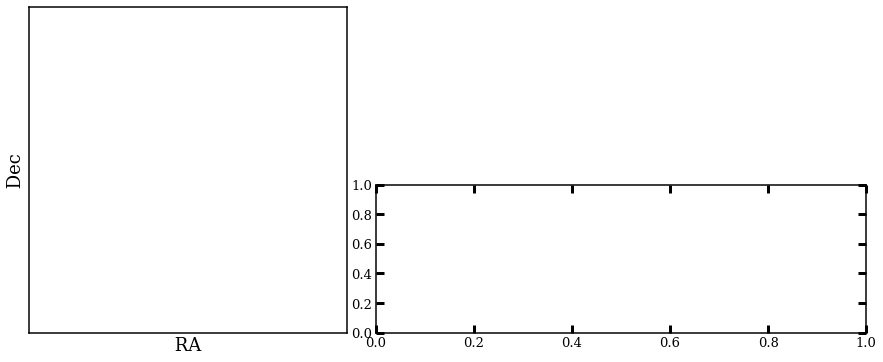

In [25]:
#proposal
fig = plt.figure(figsize=(15,6))

ax1 = plt.subplot2grid((2,5), (0, 0), colspan=2, rowspan=2)
ax2 = plt.subplot2grid((2,5), (1, 2), colspan=3,rowspan=1)
#ax3 = plt.subplot2grid((2, 5), (1, 2), colspan=3,rowspan=1)
# ax4 = plt.subplot2grid((2, 6), (0, 4), colspan=2,rowspan=1)
# ax5 = plt.subplot2grid((2, 6), (1, 4), colspan=2,rowspan=1)

velc='#a2798f'
for ax in [ax2]:
    ax.tick_params(axis='both', which='major', direction='in', length=8, width=3, bottom=True,top=True,
                  left=True, right=True, reset=True)
    ax.tick_params(axis='both', which='minor', direction='in', length=4, width=3, bottom=True,top=True,
                  left=True, right=True, reset=True)
### skymap
ax1.set_xlim([-1,1])
ax1.set_ylim([-1,1])
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xlabel(r" RA ")
ax1.set_ylabel(r" Dec ")

#host coords
hostid=147606
J=9
vhost=sightlines_table['host velocity (helio)'][J]
host_dist=sightlines_table['Host distance [Mpc]'][J]
b_host=[sightlines_table['impact parameter [kpc]'][J]]
cos_saga_hosts.add_index('HOSTID')

m = cos_saga_hosts.loc_indices[hostid]
rahost,dechost=cos_saga_hosts['RA'][m], cos_saga_hosts['DEC'][m]

ax1.scatter(0,0,c='#992959', marker='s', s=150, label='host')
ellipse=[1.37/6.,0.77/6., 125]#host orientation
ells=Ellipse(xy=(0,0), width=ellipse[0], height=ellipse[1], angle=ellipse[2]-90, ec='#992959', fc='None')
#ax1.add_artist(ells)
#sightlines
draq1,ddecq1 = rahost-sightlines_table['RA QSO'][J], dechost-sightlines_table['DEC QSO'][J]

ax1.scatter([draq1],[ddecq1],c='k', marker='*', s=200)
ax1.plot(-20,-20,c='k', marker='*', ms=20, label='QSO',ls='None' )

#satelites
cos_saga_satellites.add_index('HOSTID')
sat_n = cos_saga_satellites.loc_indices[hostid]

Dras,DDecs,DVs,Bs, Bh=[],[],[],[], []

for n in sat_n:
    if cos_saga_satellites['HOSTID'][n] == hostid:
        dras,ddecs = rahost-cos_saga_satellites['RA'][n],dechost-cos_saga_satellites['DEC'][n]
        Dras,DDecs=np.append(Dras,dras),np.append(DDecs,ddecs)


ax1.scatter(Dras,DDecs,c='#ffb250', marker='o', s=150, label='satellite')

ax1.legend(fontsize=12)

#spectra & impact param
ax=ax2
s = sightlines_table['QSO'][J]
i=J

qso_coord = SkyCoord(sightlines_table['RA QSO'][i]*u.deg,sightlines_table['DEC QSO'][i]*u.deg, distance=host_dist*u.Mpc)
DVs,Bs, Bh=[],[],[]
if np.size(sat_n)>1.:

    for n in sat_n:
        if cos_saga_satellites['HOSTID'][n] == hostid:
            dvs = (cos_saga_satellites['SPEC_Z'][n]*cnst.c - (vhost)*u.km/u.s).to(u.km/u.s)

            DVs=np.append(DVs,dvs.value)

            #impact parameter to the qso
            sat_coord = SkyCoord(cos_saga_satellites['RA'][n]*u.deg,cos_saga_satellites['DEC'][n]*u.deg,distance=host_dist*u.Mpc)
            sep = qso_coord.separation_3d(sat_coord)
            sep=sep.to(u.kpc)
            bs=sep.value
            #bs=cos_saga_satellites['RHOST_KPC'][n] 
            Bs = np.append(Bs,bs)
            bh = cos_saga_satellites['RHOST_KPC'][n] 
            Bh = np.append(Bh,bh)



#axi.scatter(Bs,DVs,c='#ffb250', marker='o', s=100)
#ax4.scatter(Bh,DVs,c='#ffb250', marker='o', s=150) 

#axi.scatter(b_host[i-6],0,c='#992959', marker='s', s=100)
print(s)
sline = pickle.load(open(s+'_1215.67.p', 'rb'))
v=sline.velo
f=sline.fnorm
e = sline.enorm -0.6
#N = round(np.log10(sline.logN),2)
ew = round(sline.W,2)
ew_er = round(sline.W_e,2)

#ax.annotate('W$_{r}$ = '+ str(ew) + ' $\pm$ '+str(ew_er), (0.05,0.85), xycoords='axes fraction', fontsize=15)
ax.set_xlim([-600,600])
#axi.set_ylim([-600,600])
ax.set_ylim([-.6,2.1])
#axi.set_xlim([-10,350])
#axi.axhline(0, ls='--', c='gray')
ax.axvline(0, ls='--',c='#992959')
ax.axhline(1.0, ls='--', c='gray')
ax.step(v,f, 'k')
#ax.step(v,e, 'r')
if np.size(DVs) > 1:
    for dvs in DVs:

        ax.plot([dvs]*2, [1.2,1.5], color='#ffb250')
        print(dvs)
#other absorbers
else:
    ax.plot([DVs[0]]*2, [1.2,1.5], color='#ffb250')
    print(DVs[0])

#ax5.set_xlabel("QSO Impact Parameter [kpc]", fontsize=18)
ax2.set_xlabel("Velocity [km/s]", fontsize=18)

# for ax in [ax4,ax5]:
#     ax.yaxis.tick_right()
#     ax.yaxis.set_label_position("right")
    
# ax4.set_ylabel("$\Delta$ v [km/s]", fontsize=18)
ax1.plot([-0.8,0.0], [-.8,-.8], lw=3,color='k')
ax1.annotate("300 kpc", xy=(-0.6,-0.75))
#ax1.annotate('HOST ID: '+str(hostid), xy=(0.1,0.9), xycoords='axes fraction')
fig.savefig(str(hostid)+'1sightline.png')


In [ ]:
fig = plt.figure(figsize=(18,6))

ax1 = plt.subplot2grid((2,5), (0, 0), colspan=2, rowspan=2)
ax2 = plt.subplot2grid((2,5), (0, 2), colspan=3,rowspan=1)
ax3 = plt.subplot2grid((2, 5), (1, 2), colspan=3,rowspan=1)
# ax4 = plt.subplot2grid((2, 6), (0, 4), colspan=2,rowspan=1)
# ax5 = plt.subplot2grid((2, 6), (1, 4), colspan=2,rowspan=1)

velc='#a2798f'
for ax in [ax1,ax2,ax3]:
    ax.tick_params(axis='both', which='major', direction='in', length=8, width=3, bottom=True,top=True,
                  left=True, right=True, reset=True)
    ax.tick_params(axis='both', which='minor', direction='in', length=4, width=3, bottom=True,top=True,
                  left=True, right=True, reset=True)
### skymap
ax1.set_xlim([-1,1])
ax1.set_ylim([-1,1])
ax1.set_xticks([-1,-0.5,0,0.5])
ax1.set_xlabel(r"$\Delta$ RA [deg]")
ax1.set_ylabel(r"$\Delta$ Dec [deg]")

#host coords
hostid=165082
J=6
vhost=sightlines_table['host velocity (helio)'][J]
host_dist=sightlines_table['Host distance [Mpc]'][J]
b_host=[sightlines_table['impact parameter [kpc]'][J],sightlines_table['impact parameter [kpc]'][J+1]]
cos_saga_hosts.add_index('HOSTID')

m = cos_saga_hosts.loc_indices[hostid]
rahost,dechost=cos_saga_hosts['RA'][m], cos_saga_hosts['DEC'][m]

ax1.scatter(0,0,c='#992959', marker='s', s=150, label='host')
ellipse=(1.41/6., 1.297/6., 145)#host orientation
ells=Ellipse(xy=(0,0), width=ellipse[0], height=ellipse[1], angle=ellipse[2]-90, ec='#992959', fc='None')
ax1.add_artist(ells)
#sightlines
draq1,ddecq1 = rahost-sightlines_table['RA QSO'][J], dechost-sightlines_table['DEC QSO'][J]
draq2,ddecq2 = rahost-sightlines_table['RA QSO'][J+1], dechost-sightlines_table['DEC QSO'][J+1]

ax1.scatter([draq1,draq2],[ddecq1,ddecq2],c='k', marker='*', s=200)
ax1.plot(-20,-20,c='k', marker='*', ms=20, label='QSO',ls='None' )

#satelites
cos_saga_satellites.add_index('HOSTID')
sat_n = cos_saga_satellites.loc_indices[hostid]

Dras,DDecs,DVs,Bs, Bh=[],[],[],[], []

for n in sat_n:
    if cos_saga_satellites['HOSTID'][n] == hostid:
        dras,ddecs = rahost-cos_saga_satellites['RA'][n],dechost-cos_saga_satellites['DEC'][n]
        Dras,DDecs=np.append(Dras,dras),np.append(DDecs,ddecs)


ax1.scatter(Dras,DDecs,c='#ffb250', marker='o', s=150, label='satellite')

ax1.legend(fontsize=12)

#spectra & impact param
for s,i,ax in zip(sightlines_table['QSO'][6:8], range(6,9), [ax2,ax3]): #axi in, [ax4,ax5]):

    qso_coord = SkyCoord(sightlines_table['RA QSO'][i]*u.deg,sightlines_table['DEC QSO'][i]*u.deg, distance=host_dist*u.Mpc)
    DVs,Bs, Bh=[],[],[]
    if np.size(sat_n)>1.:

        for n in sat_n:
            if cos_saga_satellites['HOSTID'][n] == hostid:
                dvs = (cos_saga_satellites['SPEC_Z'][n]*cnst.c - (vhost)*u.km/u.s).to(u.km/u.s)

                DVs=np.append(DVs,dvs.value)

                #impact parameter to the qso
                sat_coord = SkyCoord(cos_saga_satellites['RA'][n]*u.deg,cos_saga_satellites['DEC'][n]*u.deg,distance=host_dist*u.Mpc)
                sep = qso_coord.separation_3d(sat_coord)
                sep=sep.to(u.kpc)
                bs=sep.value
                #bs=cos_saga_satellites['RHOST_KPC'][n] 
                Bs = np.append(Bs,bs)
                bh = cos_saga_satellites['RHOST_KPC'][n] 
                Bh = np.append(Bh,bh)


    
    #axi.scatter(Bs,DVs,c='#ffb250', marker='o', s=100)
    #ax4.scatter(Bh,DVs,c='#ffb250', marker='o', s=150) 
    
    #axi.scatter(b_host[i-6],0,c='#992959', marker='s', s=100)
    print(s)
    sline = pickle.load(open(s+'_1215.67.p', 'rb'))
    v=sline.velo
    f=sline.fnorm
    e = sline.enorm -0.6
    #N = round(np.log10(sline.logN),2)
    N = round(np.log10(sline.logN),2)
    print(N)
    ew = round(sline.W,2)
    ew_er = round(sline.W_e,2)

    ax.annotate('W$_{r}$ = '+ str(ew) + ' $\pm$ '+str(ew_er), (0.05,0.85), xycoords='axes fraction', fontsize=15)
    ax.set_xlim([-600,600])
    #axi.set_ylim([-600,600])
    ax.set_ylim([-.6,2.1])
    #axi.set_xlim([-10,350])
    #axi.axhline(0, ls='--', c='gray')
    ax.axvline(0, ls='--',c='#992959')
    ax.axhline(1.0, ls='--', c='gray')
    ax.step(v,f, 'k')
    ax.step(v,e, 'r')
    if np.size(DVs) > 1:
        for dvs in DVs:
            print(dvs)
            ax.plot([dvs]*2, [1.2,1.5], color='#ffb250')
    #other absorbers
    else:
        print(DVs[0])
        ax.plot([DVs[0]]*2, [1.2,1.5], color='#ffb250')

#ax5.set_xlabel("QSO Impact Parameter [kpc]", fontsize=18)
ax3.set_xlabel("Velocity [km/s]", fontsize=18)

# for ax in [ax4,ax5]:
#     ax.yaxis.tick_right()
#     ax.yaxis.set_label_position("right")
    
# ax4.set_ylabel("$\Delta$ v [km/s]", fontsize=18)

ax1.annotate('HOST ID: '+str(hostid), xy=(0.1,0.9), xycoords='axes fraction')

fig.savefig("165082-2sightlines.png")

J1451+5914
14.22
37.815072702476755
60.04846492547263
10.295660521777346


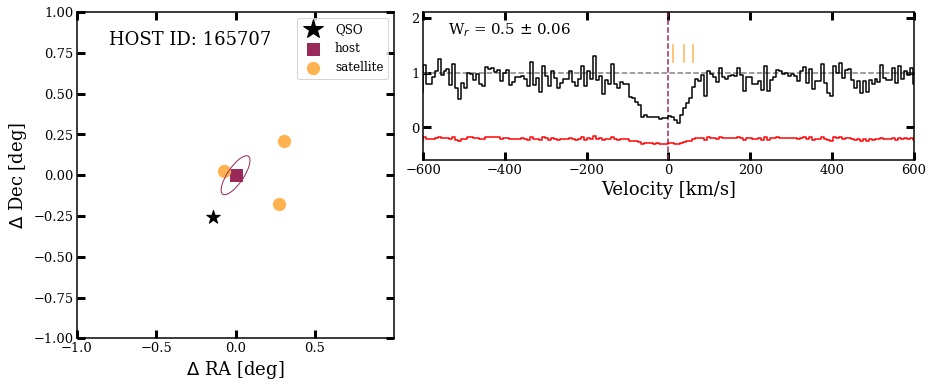

In [63]:
fig = plt.figure(figsize=(15,6))

ax1 = plt.subplot2grid((2,5), (0, 0), colspan=2, rowspan=2)
ax2 = plt.subplot2grid((2,5), (0, 2), colspan=3,rowspan=1)
#ax3 = plt.subplot2grid((2, 5), (1, 2), colspan=3,rowspan=1)
# ax4 = plt.subplot2grid((2, 6), (0, 4), colspan=2,rowspan=1)
# ax5 = plt.subplot2grid((2, 6), (1, 4), colspan=2,rowspan=1)

velc='#a2798f'
for ax in [ax1,ax2]:
    ax.tick_params(axis='both', which='major', direction='in', length=8, width=3, bottom=True,top=True,
                  left=True, right=True, reset=True)
    ax.tick_params(axis='both', which='minor', direction='in', length=4, width=3, bottom=True,top=True,
                  left=True, right=True, reset=True)
### skymap
ax1.set_xlim([-1,1])
ax1.set_ylim([-1,1])
ax1.set_xticks([-1,-0.5,0,0.5])
ax1.set_xlabel(r"$\Delta$ RA [deg]")
ax1.set_ylabel(r"$\Delta$ Dec [deg]")

#host coords
hostid=165707
J=8
vhost=sightlines_table['host velocity (helio)'][J]
host_dist=sightlines_table['Host distance [Mpc]'][J]
b_host=[sightlines_table['impact parameter [kpc]'][J],sightlines_table['impact parameter [kpc]'][J+1]]
cos_saga_hosts.add_index('HOSTID')

m = cos_saga_hosts.loc_indices[hostid]
rahost,dechost=cos_saga_hosts['RA'][m], cos_saga_hosts['DEC'][m]

ax1.scatter(0,0,c='#992959', marker='s', s=150, label='host')
ellipse=[0.85/3., 0.3/3., 145]#host orientation
ells=Ellipse(xy=(0,0), width=ellipse[0], height=ellipse[1], angle=ellipse[2]-90, ec='#992959', fc='None')
ax1.add_artist(ells)
#sightlines
draq1,ddecq1 = rahost-sightlines_table['RA QSO'][J], dechost-sightlines_table['DEC QSO'][J]
draq2,ddecq2 = rahost-sightlines_table['RA QSO'][J+1], dechost-sightlines_table['DEC QSO'][J+1]

ax1.scatter([draq1,draq2],[ddecq1,ddecq2],c='k', marker='*', s=200)
ax1.plot(-20,-20,c='k', marker='*', ms=20, label='QSO',ls='None' )

#satelites
cos_saga_satellites.add_index('HOSTID')
sat_n = cos_saga_satellites.loc_indices[hostid]

Dras,DDecs,DVs,Bs, Bh=[],[],[],[], []

for n in sat_n:
    if cos_saga_satellites['HOSTID'][n] == hostid:
        dras,ddecs = rahost-cos_saga_satellites['RA'][n],dechost-cos_saga_satellites['DEC'][n]
        Dras,DDecs=np.append(Dras,dras),np.append(DDecs,ddecs)


ax1.scatter(Dras,DDecs,c='#ffb250', marker='o', s=150, label='satellite')

ax1.legend(fontsize=12)

#spectra & impact param
ax=ax2
s = sightlines_table['QSO'][8]
i=8

qso_coord = SkyCoord(sightlines_table['RA QSO'][i]*u.deg,sightlines_table['DEC QSO'][i]*u.deg, distance=host_dist*u.Mpc)
DVs,Bs, Bh=[],[],[]
if np.size(sat_n)>1.:

    for n in sat_n:
        if cos_saga_satellites['HOSTID'][n] == hostid:
            dvs = (cos_saga_satellites['SPEC_Z'][n]*cnst.c - (vhost)*u.km/u.s).to(u.km/u.s)

            DVs=np.append(DVs,dvs.value)

            #impact parameter to the qso
            sat_coord = SkyCoord(cos_saga_satellites['RA'][n]*u.deg,cos_saga_satellites['DEC'][n]*u.deg,distance=host_dist*u.Mpc)
            sep = qso_coord.separation_3d(sat_coord)
            sep=sep.to(u.kpc)
            bs=sep.value
            #bs=cos_saga_satellites['RHOST_KPC'][n] 
            Bs = np.append(Bs,bs)
            bh = cos_saga_satellites['RHOST_KPC'][n] 
            Bh = np.append(Bh,bh)



#axi.scatter(Bs,DVs,c='#ffb250', marker='o', s=100)
#ax4.scatter(Bh,DVs,c='#ffb250', marker='o', s=150) 

#axi.scatter(b_host[i-6],0,c='#992959', marker='s', s=100)
print(s)
sline = pickle.load(open(s+'_1215.67.p', 'rb'))
v=sline.velo
f=sline.fnorm
e = sline.enorm -0.6
N = round(np.log10(sline.logN),2)
print(N)
ew = round(sline.W,2)
ew_er = round(sline.W_e,2)

ax.annotate('W$_{r}$ = '+ str(ew) + ' $\pm$ '+str(ew_er), (0.05,0.85), xycoords='axes fraction', fontsize=15)
ax.set_xlim([-600,600])
#axi.set_ylim([-600,600])
ax.set_ylim([-.6,2.1])
#axi.set_xlim([-10,350])
#axi.axhline(0, ls='--', c='gray')
ax.axvline(0, ls='--',c='#992959')
ax.axhline(1.0, ls='--', c='gray')
ax.step(v,f, 'k')
ax.step(v,e, 'r')
if np.size(DVs) > 1:
    for dvs in DVs:
        print(dvs)
        ax.plot([dvs]*2, [1.2,1.5], color='#ffb250')
#other absorbers
else:
    ax.plot([DVs[0]]*2, [1.2,1.5], color='#ffb250')
    print(DVs[0])
#ax5.set_xlabel("QSO Impact Parameter [kpc]", fontsize=18)
ax2.set_xlabel("Velocity [km/s]", fontsize=18)

# for ax in [ax4,ax5]:
#     ax.yaxis.tick_right()
#     ax.yaxis.set_label_position("right")
    
# ax4.set_ylabel("$\Delta$ v [km/s]", fontsize=18)

ax1.annotate('HOST ID: '+str(hostid), xy=(0.1,0.9), xycoords='axes fraction')
fig.savefig(str(hostid)+'1sightline.png')


SBS1421+511
13.85
75.24162515848224
169.37633614908344
-65.96065073003247
0.2934983735289425
-180.18153955119755


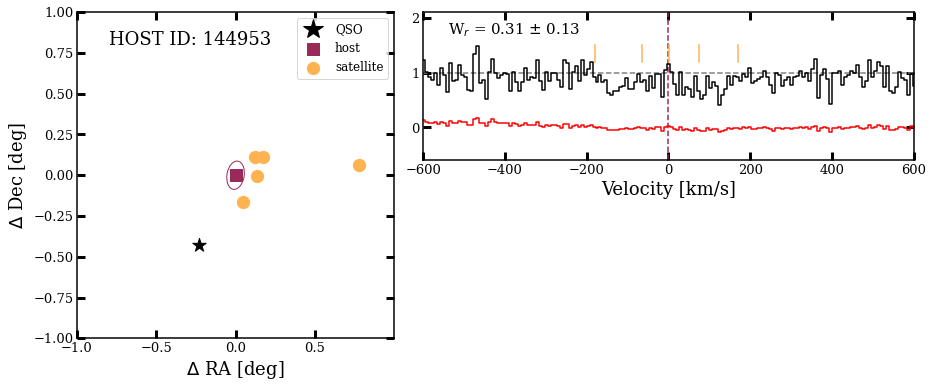

In [64]:
fig = plt.figure(figsize=(15,6))

ax1 = plt.subplot2grid((2,5), (0, 0), colspan=2, rowspan=2)
ax2 = plt.subplot2grid((2,5), (0, 2), colspan=3,rowspan=1)
#ax3 = plt.subplot2grid((2, 5), (1, 2), colspan=3,rowspan=1)
# ax4 = plt.subplot2grid((2, 6), (0, 4), colspan=2,rowspan=1)
# ax5 = plt.subplot2grid((2, 6), (1, 4), colspan=2,rowspan=1)

velc='#a2798f'
for ax in [ax1,ax2]:
    ax.tick_params(axis='both', which='major', direction='in', length=8, width=3, bottom=True,top=True,
                  left=True, right=True, reset=True)
    ax.tick_params(axis='both', which='minor', direction='in', length=4, width=3, bottom=True,top=True,
                  left=True, right=True, reset=True)
### skymap
ax1.set_xlim([-1,1])
ax1.set_ylim([-1,1])
ax1.set_xticks([-1,-0.5,0,0.5])
ax1.set_xlabel(r"$\Delta$ RA [deg]")
ax1.set_ylabel(r"$\Delta$ Dec [deg]")

#host coords
hostid=144953
J=5
vhost=sightlines_table['host velocity (helio)'][J]
host_dist=sightlines_table['Host distance [Mpc]'][J]
b_host=[sightlines_table['impact parameter [kpc]'][J],sightlines_table['impact parameter [kpc]'][J+1]]
cos_saga_hosts.add_index('HOSTID')

m = cos_saga_hosts.loc_indices[hostid]
rahost,dechost=cos_saga_hosts['RA'][m], cos_saga_hosts['DEC'][m]

ax1.scatter(0,0,c='#992959', marker='s', s=150, label='host')
ellipse=[1.05/6., 0.65/6., 170]#host orientation
ells=Ellipse(xy=(0,0), width=ellipse[0], height=ellipse[1], angle=ellipse[2]-90, ec='#992959', fc='None')
ax1.add_artist(ells)
#sightlines
draq1,ddecq1 = rahost-sightlines_table['RA QSO'][J], dechost-sightlines_table['DEC QSO'][J]
draq2,ddecq2 = rahost-sightlines_table['RA QSO'][J+1], dechost-sightlines_table['DEC QSO'][J+1]

ax1.scatter([draq1,draq2],[ddecq1,ddecq2],c='k', marker='*', s=200)
ax1.plot(-20,-20,c='k', marker='*', ms=20, label='QSO',ls='None' )

#satelites
cos_saga_satellites.add_index('HOSTID')
sat_n = cos_saga_satellites.loc_indices[hostid]

Dras,DDecs,DVs,Bs, Bh=[],[],[],[], []

for n in sat_n:
    if cos_saga_satellites['HOSTID'][n] == hostid:
        dras,ddecs = rahost-cos_saga_satellites['RA'][n],dechost-cos_saga_satellites['DEC'][n]
        Dras,DDecs=np.append(Dras,dras),np.append(DDecs,ddecs)


ax1.scatter(Dras,DDecs,c='#ffb250', marker='o', s=150, label='satellite')

ax1.legend(fontsize=12)

#spectra & impact param
ax=ax2
s = sightlines_table['QSO'][J]
i=J

qso_coord = SkyCoord(sightlines_table['RA QSO'][i]*u.deg,sightlines_table['DEC QSO'][i]*u.deg, distance=host_dist*u.Mpc)
DVs,Bs, Bh=[],[],[]
if np.size(sat_n)>1.:

    for n in sat_n:
        if cos_saga_satellites['HOSTID'][n] == hostid:
            dvs = (cos_saga_satellites['SPEC_Z'][n]*cnst.c - (vhost)*u.km/u.s).to(u.km/u.s)

            DVs=np.append(DVs,dvs.value)

            #impact parameter to the qso
            sat_coord = SkyCoord(cos_saga_satellites['RA'][n]*u.deg,cos_saga_satellites['DEC'][n]*u.deg,distance=host_dist*u.Mpc)
            sep = qso_coord.separation_3d(sat_coord)
            sep=sep.to(u.kpc)
            bs=sep.value
            #bs=cos_saga_satellites['RHOST_KPC'][n] 
            Bs = np.append(Bs,bs)
            bh = cos_saga_satellites['RHOST_KPC'][n] 
            Bh = np.append(Bh,bh)



#axi.scatter(Bs,DVs,c='#ffb250', marker='o', s=100)
#ax4.scatter(Bh,DVs,c='#ffb250', marker='o', s=150) 

#axi.scatter(b_host[i-6],0,c='#992959', marker='s', s=100)
print(s)
sline = pickle.load(open(s+'_1215.67.p', 'rb'))
v=sline.velo
f=sline.fnorm
e = sline.enorm -0.6
N = round(np.log10(sline.logN),2)
print(N)
ew = round(sline.W,2)
ew_er = round(sline.W_e,2)

ax.annotate('W$_{r}$ = '+ str(ew) + ' $\pm$ '+str(ew_er), (0.05,0.85), xycoords='axes fraction', fontsize=15)
ax.set_xlim([-600,600])
#axi.set_ylim([-600,600])
ax.set_ylim([-.6,2.1])
#axi.set_xlim([-10,350])
#axi.axhline(0, ls='--', c='gray')
ax.axvline(0, ls='--',c='#992959')
ax.axhline(1.0, ls='--', c='gray')
ax.step(v,f, 'k')
ax.step(v,e, 'r')
if np.size(DVs) > 1:
    for dvs in DVs:
        print(dvs)
        ax.plot([dvs]*2, [1.2,1.5], color='#ffb250')
#other absorbers
else:
    ax.plot([DVs[0]]*2, [1.2,1.5], color='#ffb250')
    print(DVs[0])
#ax5.set_xlabel("QSO Impact Parameter [kpc]", fontsize=18)
ax2.set_xlabel("Velocity [km/s]", fontsize=18)

# for ax in [ax4,ax5]:
#     ax.yaxis.tick_right()
#     ax.yaxis.set_label_position("right")
    
# ax4.set_ylabel("$\Delta$ v [km/s]", fontsize=18)

ax1.annotate('HOST ID: '+str(hostid), xy=(0.1,0.9), xycoords='axes fraction')
fig.savefig(str(hostid)+'1sightline.png')


J1700+2237
14.13


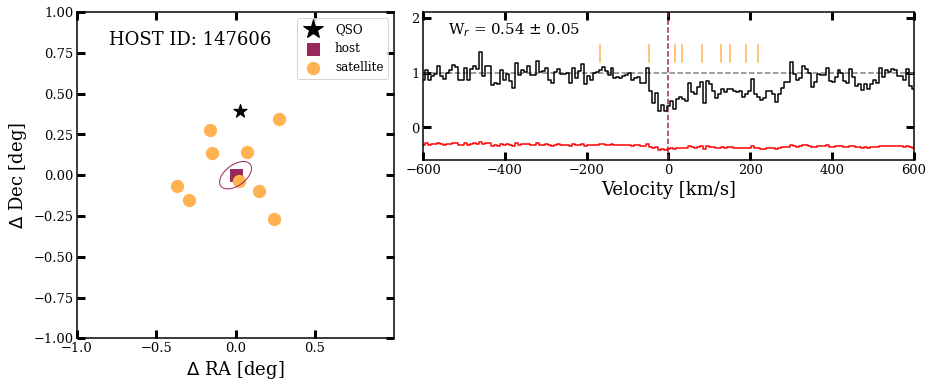

In [97]:
fig = plt.figure(figsize=(15,6))

ax1 = plt.subplot2grid((2,5), (0, 0), colspan=2, rowspan=2)
ax2 = plt.subplot2grid((2,5), (0, 2), colspan=3,rowspan=1)
#ax3 = plt.subplot2grid((2, 5), (1, 2), colspan=3,rowspan=1)
# ax4 = plt.subplot2grid((2, 6), (0, 4), colspan=2,rowspan=1)
# ax5 = plt.subplot2grid((2, 6), (1, 4), colspan=2,rowspan=1)

velc='#a2798f'
for ax in [ax1,ax2]:
    ax.tick_params(axis='both', which='major', direction='in', length=8, width=3, bottom=True,top=True,
                  left=True, right=True, reset=True)
    ax.tick_params(axis='both', which='minor', direction='in', length=4, width=3, bottom=True,top=True,
                  left=True, right=True, reset=True)
### skymap
ax1.set_xlim([-1,1])
ax1.set_ylim([-1,1])
ax1.set_xticks([-1,-0.5,0,0.5])
ax1.set_xlabel(r"$\Delta$ RA [deg]")
ax1.set_ylabel(r"$\Delta$ Dec [deg]")

#host coords
hostid=147606
J=9
vhost=sightlines_table['host velocity (helio)'][J]
host_dist=sightlines_table['Host distance [Mpc]'][J]
b_host=[sightlines_table['impact parameter [kpc]'][J]]
cos_saga_hosts.add_index('HOSTID')

m = cos_saga_hosts.loc_indices[hostid]
rahost,dechost=cos_saga_hosts['RA'][m], cos_saga_hosts['DEC'][m]

ax1.scatter(0,0,c='#992959', marker='s', s=150, label='host')
ellipse=[1.37/6.,0.77/6., 125]#host orientation
ells=Ellipse(xy=(0,0), width=ellipse[0], height=ellipse[1], angle=ellipse[2]-90, ec='#992959', fc='None')
ax1.add_artist(ells)
#sightlines
draq1,ddecq1 = rahost-sightlines_table['RA QSO'][J], dechost-sightlines_table['DEC QSO'][J]


ax1.scatter([draq1,draq2],[ddecq1,ddecq2],c='k', marker='*', s=200)
ax1.plot(-20,-20,c='k', marker='*', ms=20, label='QSO',ls='None' )

#satelites
cos_saga_satellites.add_index('HOSTID')
sat_n = cos_saga_satellites.loc_indices[hostid]

Dras,DDecs,DVs,Bs, Bh=[],[],[],[], []

for n in sat_n:
    if cos_saga_satellites['HOSTID'][n] == hostid:
        dras,ddecs = rahost-cos_saga_satellites['RA'][n],dechost-cos_saga_satellites['DEC'][n]
        Dras,DDecs=np.append(Dras,dras),np.append(DDecs,ddecs)


ax1.scatter(Dras,DDecs,c='#ffb250', marker='o', s=150, label='satellite')

ax1.legend(fontsize=12)

#spectra & impact param
ax=ax2
s = sightlines_table['QSO'][J]
i=J

qso_coord = SkyCoord(sightlines_table['RA QSO'][i]*u.deg,sightlines_table['DEC QSO'][i]*u.deg, distance=host_dist*u.Mpc)
DVs,Bs, Bh=[],[],[]
if np.size(sat_n)>1.:

    for n in sat_n:
        if cos_saga_satellites['HOSTID'][n] == hostid:
            dvs = (cos_saga_satellites['SPEC_Z'][n]*cnst.c - (vhost)*u.km/u.s).to(u.km/u.s)

            DVs=np.append(DVs,dvs.value)

            #impact parameter to the qso
            sat_coord = SkyCoord(cos_saga_satellites['RA'][n]*u.deg,cos_saga_satellites['DEC'][n]*u.deg,distance=host_dist*u.Mpc)
            sep = qso_coord.separation_3d(sat_coord)
            sep=sep.to(u.kpc)
            bs=sep.value
            #bs=cos_saga_satellites['RHOST_KPC'][n] 
            Bs = np.append(Bs,bs)
            bh = cos_saga_satellites['RHOST_KPC'][n] 
            Bh = np.append(Bh,bh)



#axi.scatter(Bs,DVs,c='#ffb250', marker='o', s=100)
#ax4.scatter(Bh,DVs,c='#ffb250', marker='o', s=150) 

#axi.scatter(b_host[i-6],0,c='#992959', marker='s', s=100)
print(s)
sline = pickle.load(open(s+'_1215.67.p', 'rb'))
v=sline.velo
f=sline.fnorm
e = sline.enorm -0.6
N = round(np.log10(sline.logN),2)
print(N)
ew = round(sline.W,2)
ew_er = round(sline.W_e,2)

ax.annotate('W$_{r}$ = '+ str(ew) + ' $\pm$ '+str(ew_er), (0.05,0.85), xycoords='axes fraction', fontsize=15)
ax.set_xlim([-600,600])
#axi.set_ylim([-600,600])
ax.set_ylim([-.6,2.1])
#axi.set_xlim([-10,350])
#axi.axhline(0, ls='--', c='gray')
ax.axvline(0, ls='--',c='#992959')
ax.axhline(1.0, ls='--', c='gray')
ax.step(v,f, 'k')
ax.step(v,e, 'r')
if np.size(DVs) > 1:
    for dvs in DVs:

        ax.plot([dvs]*2, [1.2,1.5], color='#ffb250')
#other absorbers
else:
    ax.plot([DVs[0]]*2, [1.2,1.5], color='#ffb250')

#ax5.set_xlabel("QSO Impact Parameter [kpc]", fontsize=18)
ax2.set_xlabel("Velocity [km/s]", fontsize=18)

# for ax in [ax4,ax5]:
#     ax.yaxis.tick_right()
#     ax.yaxis.set_label_position("right")
    
# ax4.set_ylabel("$\Delta$ v [km/s]", fontsize=18)

ax1.annotate('HOST ID: '+str(hostid), xy=(0.1,0.9), xycoords='axes fraction')
fig.savefig(str(hostid)+'1sightline.png')


## Classification of the absorption lines in the COS data

### TON1129	(J0956+3226) 

<b>QSO =  0.52611 </b> <br>
<b> 85746 SAGA host = 0.00477 (center of the HI line) 0.0048377 - host z </b> <br>
   -  HI 1215 glow line sits in the deep - MW HI abs?
   - SAGA host z = 0.00483777 velocity shift on HI - center of the line on 0.00477
        lines: HI 1215 - low NHI potentially multi component, NI 1206, Si IV 1402 in very broad damped feature
   - broad \lambda 1406 feature is consistent with DLA at 0.1574 and with HI 920-923 from the QSO and with Si IV from z    
   1. MW 0.0
   2. QSO 0.52611
   3. SAGA 0.00477
   4. DLA 0.1574 (?)
   
 Other absorbers:  
 -  0.36427
  - 0.22408
  - 0.21488
  - 0.01699
   
   
  

In [24]:
sightline='TON1129'
ton1129_abs = np.array([0.0,0.52611,0.1574,0.36427, 0.22408, 0.21488, 0.01699])


In [25]:
# ton1129_abs = np.array([0.0,0.52611,0.1574,0.36427, 0.22408, 0.21488, 0.01699])
# #plot_lines_vel_zoom(sightline='TON1129', vhost=sightlines_table['host velocity (helio)'][0], smoothing=5)
# plot_lines_mark_abs(sightline='TON1129', vhost=sightlines_table['host velocity (helio)'][0], smoothing=5, absorbers=ton1129_abs,hostid=85746)


In [26]:
# sightline='TON1129'
# ton1129_abs = np.array([0.0,0.52611,0.1574,0.36427, 0.22408, 0.21488, 0.01699])
# CosSaga.plot_b_vel(sightline=sightline, absorbers=ton1129_abs, maj_ax=True, ellipse=(1.86/60*10,0.67/60.*10,105 ))

In [27]:
# sightline='TON1129'
# ton1129_abs = np.array([0.0,0.52611,0.1574,0.36427, 0.22408, 0.21488, 0.01699])
# plot_lines_stack(sightline=sightline, absorbers=ton1129_abs, fit_order=7)


### J0958+3224

<b> QSO z = 0.5306 </b> <br>
<b> 85746 SAGA 0.0048377: </b> DLA/sub-DLA, Si IV doublet blended with QSO lines, NI 1200c blended with QSO and MW lines <br>

  1. MW 0.0
  2. QSO 0.5306	
  3. SAGA 0.0048377
  
  Other absorbers: <br>
   - 0.37084
   - 0.36244
    - 0.35471 ?
    - 0.13586
   - 0.13080
   - 0.07961 ? or 0.27948
   - 0.26298 ?
   - 0.23103 ?

In [28]:
# sightline='J0958+3224'
# j0958_abs = np.array([0.0,0.5306,0.37084,0.36244, 0.35471, 0.13586, 0.13080, 0.07961, 0.27948, 0.26298, 0.23103])
# plot_cont_fit(sightline, fit_order=7)

In [29]:
# j0958_abs = np.array([0.0,0.5306,0.37084,0.36244, 0.35471, 0.13586, 0.13080, 0.07961, 0.27948, 0.26298, 0.23103])
# #plot_lines_vel_zoom(sightline='TON1129', vhost=sightlines_table['host velocity (helio)'][0], smoothing=5)
# plot_lines_mark_abs(sightline='J0958+3224', vhost=sightlines_table['host velocity (helio)'][1], smoothing=5, absorbers=j0958_abs,hostid=85746 )


In [30]:
# sightline='J0958+3224'
# j0958_abs = np.array([0.0,0.5306,0.37084,0.36244, 0.35471, 0.13586, 0.13080, 0.07961, 0.27948, 0.26298, 0.23103])

# plot_b_vel(sightline='J0958+3224', absorbers=j0958_abs, N=1, maj_ax=True, ellipse=(1.86/60*10,0.67/60.*10,105 ))
                                                                               
                                                                                      

In [31]:
# sightline='J0958+3224'
# j0958_abs = np.array([0.0,0.5306,0.37084,0.36244, 0.35471, 0.13586, 0.13080, 0.07961, 0.27948, 0.26298, 0.23103])

# plot_lines_stack(sightline=sightline, absorbers=j0958_abs)


### J0959+3203

<b> QSO z = 0.56462 </b> <br>
<b> 85746 SAGA z = 0.0048377 </b> :center of H line 0.00507, SiV not convincing <br>

  1. MW 0.0
  2. QSO 0.56462
  3. SAGA 0.0048377 
  
  Other absorbers:
   - 0.29919
    - 0.32053 ?
   - 0.25209
    - 0.05500


In [32]:
# sightline='J0959+3203'
# j0959_abs = np.array([0.0,0.56462, 0.29919, 0.32053, 0.25209, 0.05500])
# plot_cont_fit(sightline, fit_order=7)

In [33]:
# j0959_abs = np.array([0.0,0.56462, 0.29919, 0.32053, 0.25209, 0.05500])
# #plot_lines_vel_zoom(sightline='TON1129', vhost=sightlines_table['host velocity (helio)'][0], smoothing=5)
# plot_lines_mark_abs(sightline='J0959+3203', vhost=sightlines_table['host velocity (helio)'][2], smoothing=5, absorbers=j0959_abs, hostid=85746)

In [34]:
# sightline='J0959+3203'
# j0959_abs = np.array([0.0,0.56462, 0.29919, 0.32053, 0.25209, 0.05500])
# plot_b_vel(sightline=sightline, absorbers=j0959_abs, N=2, maj_ax=True, ellipse=(1.86/60*10,0.67/60.*10,105 ))

In [35]:
# sightline='J0959+3203'
# j0959_abs = np.array([0.0,0.56462, 0.29919, 0.32053, 0.25209, 0.05500])
# plot_lines_stack(sightline=sightline, absorbers=j0959_abs)

### J1202-0129 ?
<b> QSO z=0.15069 </b> strong intrinsic aborption from HI +emission <br>
<b> 140594 SAGA 0.004883 </b>- velocity correciton for HI z = 0.00496, potentially very faint Si IV , HI low N <br>
   
   - low -z QSO I cannot identify most of the lines

 1. MW 0.0
 2. QSO 0.15069 
 3. SAGA 0.0048833
 
 
 Other absorbers:
- 0.12698 ?
       

In [36]:
sightline='J1202-0129'
j1202_abs = np.array([0.0,0.15069, 0.12698])
plot_cont_fit(sightline, fit_order=10)

NameError: name 'plot_cont_fit' is not defined

In [ ]:
# j1202_abs = np.array([0.0,0.15069, 0.12698])
# #plot_lines_vel_zoom(sightline='TON1129', vhost=sightlines_table['host velocity (helio)'][0], smoothing=5)
# plot_lines_mark_abs(sightline='J1202-0129', vhost=sightlines_table['host velocity (helio)'][3], smoothing=5, absorbers=j1202_abs, hostid=140594)

In [ ]:

# plot_b_vel(sightline=sightline, absorbers=j1202_abs, maj_ax=True, ellipse=[2.18/6., 1.87/6., 40])


In [ ]:
# plot_lines_stack(sightline=sightline, absorbers=j1202_abs)


2 satellites

### J1202+0225
<b> QSO z = 0.27364 </b> <br>
<b> 13927 SAGA z = 0.006537 </b> very faint HI: centered ont he HI z= 0.00662, a asymetric component redwise <br>
   
 1. MW 0.0 
 2. QSO 0.27364	
 3. SAGA 0.006537
    
 Other absorbers:
  - 0.13945 ?
  - 0.12705
  - 0.02014
  - 0.00417
  

no satellites

In [ ]:
# sightline="J1202+0225"
# j120202_abs = np.array([0.0,0.27364, 0.13945, 0.12705, 0.02014,0.00417])
# plot_cont_fit(sightline, fit_order=7)

In [ ]:
# j120202_abs = np.array([0.0,0.27364, 0.13945, 0.12705, 0.02014,0.00417])
# #plot_lines_vel_zoom(sightline='TON1129', vhost=sightlines_table['host velocity (helio)'][0], smoothing=5)
# sightline="J1202+0225"
# j120202_abs = np.array([0.0,0.27364, 0.13945, 0.12705, 0.02014,0.00417])plot_lines_mark_abs(sightline='J1202+0225', vhost=sightlines_table['host velocity (helio)'][4], smoothing=5, absorbers=j120202_abs, hostid=13927)

In [ ]:
# sightline="J1202+0225"
# j120202_abs = np.array([0.0,0.27364, 0.13945, 0.12705, 0.02014,0.00417])
# plot_b_vel(sightline=sightline, absorbers=j120202_abs,maj_ax=True, ellipse=(1.05/6., 0.987/6., 170 ))

In [ ]:
# plot_lines_stack(sightline=sightline, absorbers=j120202_abs)


### J1423+5055 -  SBS1421+511
<b> QSO z = 0.27622 </b> does this QSO has a in/out flow? all HI lines align bu a but shifted form centroid <br>
<b> 144953 SAGA z = 0.00743 </b> very faint HI z= 0.00759 and potentially second component 0.00676 <br>

1. MW 0.0
2. QSO 0.27662
3. SAGa 0.00743

Other absorbers:
- 0.17252
- 0.13268
- 0.06474


In [ ]:
# sightline='SBS1421+511'
# j1423_abs = np.array([0.0,0.27662, 0.17252, 0.13266, 0.06474])
# plot_cont_fit(sightline, fit_order=10)

In [ ]:

# #plot_lines_vel_zoom(sightline='TON1129', vhost=sightlines_table['host velocity (helio)'][0], smoothing=5)
# plot_lines_mark_abs(sightline='SBS1421+511', vhost=sightlines_table['host velocity (helio)'][5], smoothing=5, absorbers=j1423_abs, hostid=144953)


In [ ]:
# sightline='SBS1421+511'
# j1423_abs = np.array([0.0,0.27662, 0.17252, 0.13266, 0.06474])
# plot_b_vel(sightline=sightline, absorbers=j1423_abs, maj_ax=True, ellipse=[1.05/6., 0.65/6., 170])

In [ ]:
# plot_lines_stack(sightline=sightline, absorbers=j1423_abs)


### J1429+0321

<b> QSO z = 0.25344 </b> <br>
<b> 165082 SAGA z = 0.00541 </b> <br>

1. MW 0.0
2. QSO 0.25344	
3. SAGA 0.00541

Other absorbers:

- 0.15505
- 0.13825

no satellites

In [ ]:
# sightline='J1429+0321'
# j1429_abs = np.array([0.0,0.25344, 0.15505, 0.13825])
# plot_cont_fit(sightline, fit_order=7)

In [ ]:
# j1429_abs = np.array([0.0,0.25344, 0.15505, 0.13825])
# #plot_lines_vel_zoom(sightline='TON1129', vhost=sightlines_table['host velocity (helio)'][0], smoothing=5)
# plot_lines_mark_abs(sightline='J1429+0321', vhost=sightlines_table['host velocity (helio)'][6], smoothing=5, absorbers=j1429_abs, hostid=165082)


In [ ]:
# sightline='J1429+0321'
# j1429_abs = np.array([0.0,0.25344, 0.15505, 0.13825])
# plot_b_vel(sightline=sightline, absorbers=j1429_abs, N=6, maj_ax=True, ellipse=(1.41/6., 1.297/6., 145))

In [ ]:
# plot_lines_stack(sightline=sightline, absorbers=j1429_abs)


### J1431+0301

<b> QSO z = 0.34055</b> <br>
<b>  165082 SAGA z = 0.00632797 </b> no HI <br>

1. MW 0.0
2. QSO 0.25344
3. SAGA 0.0054067

Other absorbers:
- DLA at 0.00510 
-  0.15320
- 0.10339
                       

In [ ]:
# sightline="J1431+0301"
# j1431_abs = np.array([0.0,0.25344, 0.00510, 0.15320, 0.10339])
# #plot_lines_vel_zoom(sightline='TON1129', vhost=sightlines_table['host velocity (helio)'][0], smoothing=5)
# plot_cont_fit(sightline, fit_order=0)

In [ ]:
# plot_lines_mark_abs(sightline='J1431+0301', vhost=sightlines_table['host velocity (helio)'][7], smoothing=1, absorbers=j1431_abs, hostid=165082)


In [ ]:
# sightline="J1431+0301"
# j1431_abs = np.array([0.0,0.25344, 0.00510, 0.15320, 0.10339])
# maj_ax=True
# ellipse=(1.41/6., 1.297/6., 145)
# sightlines_table.add_index('QSO')
# k = sightlines_table.loc_indices[sightline]
# vhost=sightlines_table['host velocity (helio)'][k]
# zqso=sightlines_table['z QSO'][k]
# hostid=sightlines_table['SAGA NSAID'][k]
# host_dist=sightlines_table['Host distance [Mpc]'][k]
# b_host=sightlines_table['impact parameter [kpc]'][k]

# cos_saga_hosts.add_index('HOSTID')
# m = cos_saga_hosts.loc_indices[hostid]
# rahost,dechost=cos_saga_hosts['RA'][m], cos_saga_hosts['DEC'][m]
# if cos_saga_hosts['No SATELLITES'][m] != 0:
#     cos_saga_satellites.add_index('HOSTID')
#     sat_n = cos_saga_satellites.loc_indices[hostid]

# ## fid the id from satelites table


# # For multi-sightline hosts, sightline no


# # coords
# qso_coord = SkyCoord(sightlines_table['RA QSO'][k]*u.deg, sightlines_table['DEC QSO'][k]*u.deg, distance=host_dist*u.Mpc)



# #read the spectrum
# file=directory+sightline+"/Data/"+sightline+"_nbin3_coadd.fits"
# print(sightline)
# hdul = fits.open(file)
# #redshift
# zhost=vhost/3.e5

# wl = hdul['WAVELENGTH'].data
# fx = hdul['FLUX'].data
# fx_smooth = convolution.convolve(fx,convolution.Gaussian1DKernel(smoothing))
# error=hdul['ERROR'].data

# flux_cont =  fx_smooth#/out[0]
# err_cont = error#/out[0]

# # plot figure 
# velc='#a2798f'
# fig=plt.figure(figsize=(22,6))
# gs=fig.add_gridspec(2,7, wspace=0.3)

# ax1=fig.add_subplot(gs[:2,:2])
# ax2=fig.add_subplot(gs[:2,5:], )
# ax3=fig.add_subplot(gs[:2,4], sharey=ax2)
# ax4 = fig.add_subplot(gs[:2, 2:4])
# ax1.set_xlim([-1,1])
# ax1.set_ylim([-1,1])
# ax1.set_xlabel(r"$\Delta$ RA [deg]")
# ax1.set_ylabel(r"$\Delta$ Dec [deg]")

# ax2.set_xlim([-10,350])
# ax2.set_ylim([-500,500])

# ax4.set_xlim([-10,350])
# ax4.set_ylim([-500,500])

# ax2.set_xlabel("QSO Impact Parameter [kpc]")
# ax2.set_ylabel("$\Delta$ v [km/s]")

# ax4.set_xlabel("HOST Impact Parameter [kpc]")

# ax2.yaxis.tick_right()
# ax2.yaxis.set_label_position("right")
# ax1.scatter(0,0,c='#992959', marker='s', s=150)
# ax4.scatter(0,0,c='#992959', marker='s', s=150)
# ax2.scatter(b_host,0,c='#992959', marker='s', s=150)
# ax2.axhline(0, ls='--',c=velc)
# ax3.axhline(0, ls='--',c=velc)
# ax4.axhline(0, ls='--',c=velc)
# ## choose the HI 
# line = 1215.6700
# linename="HI 1215"

# vel = (wl0 - line)/line*3.e5
# wmin,wmax=np.min(wl0[np.nonzero(wl0)]), np.max(wl0[np.nonzero(wl0)])

# ax3.plot(convolution.convolve(flux_cont,convolution.Gaussian1DKernel(2)),vel,c='k', lw=2) #in host restframe
# ax3.set_title(linename)

# ax3.set_xlim(.5e-15,-1e-16) #TO DO make the zoom in local
# ax3.axvline(1.0, ls='--', c='gray')

# #plot satellites

# Dras,DDecs,DVs,Bs, Bh=[],[],[],[], []
# if cos_saga_hosts['No SATELLITES'][m] != 0:

#     if np.size(sat_n)>1.:

#         for n in sat_n:
#             if cos_saga_satellites['HOSTID'][n] == hostid:
#                 dras,ddecs = rahost-cos_saga_satellites['RA'][n],dechost-cos_saga_satellites['DEC'][n]
#                 Dras,DDecs=np.append(Dras,dras),np.append(DDecs,ddecs)

#                 dvs = (cos_saga_satellites['SPEC_Z'][n]*cnst.c - (vhost)*u.km/u.s).to(u.km/u.s)
#                 ax2.axhline(dvs.value, ls='--',c=velc)
#                 ax3.axhline(dvs.value, ls='--',c=velc)
#                 ax4.axhline(dvs.value, ls='--',c=velc)
#                 DVs=np.append(DVs,dvs.value)

#                 #impact parameter to the qso
#                 sat_coord = SkyCoord(cos_saga_satellites['RA'][n]*u.deg,cos_saga_satellites['DEC'][n]*u.deg,distance=host_dist*u.Mpc)
#                 sep = qso_coord.separation_3d(sat_coord)
#                 sep=sep.to(u.kpc)
#                 bs=sep.value
#                 #bs=cos_saga_satellites['RHOST_KPC'][n] 
#                 Bs = np.append(Bs,bs)
#                 bh = cos_saga_satellites['RHOST_KPC'][n] 
#                 Bh = np.append(Bh,bh)
#     else:
#         dras,ddecs = rahost-cos_saga_satellites['RA'][sat_n],dechost-cos_saga_satellites['DEC'][sat_n]
#         Dras,DDecs=np.append(Dras,dras),np.append(DDecs,ddecs)

#         dvs = (cos_saga_satellites['SPEC_Z'][sat_n]*cnst.c - (vhost)*u.km/u.s).to(u.km/u.s)
#         DVs=np.append(DVs,dvs.value)
#         ax2.axhline(dvs.value, ls='--',c=velc)
#         ax3.axhline(dvs.value, ls='--',c=velc)
#         ax4.axhline(dvs.value, ls='--',c=velc)
#         #impact parameter to the qso
#         sat_coord = SkyCoord(cos_saga_satellites['RA'][sat_n]*u.deg,cos_saga_satellites['DEC'][sat_n]*u.deg,distance=host_dist*u.Mpc)
#         sep = qso_coord.separation_3d(sat_coord)
#         sep=sep.to(u.kpc)
#         Bs=sep.value#cos_saga_satellites['RHOST_KPC'][n] 
#         Bh = cos_saga_satellites['RHOST_KPC'][sat_n] 
#        # Bs = np.append(Bs,bs)
# print(Dras, DDecs)
# ax1.scatter(Dras,DDecs,c='#ffb250', marker='o', s=150)     
# ax2.scatter(Bs,DVs,c='#ffb250', marker='o', s=150)
# ax4.scatter(Bh,DVs,c='#ffb250', marker='o', s=150)

# for m in range(np.size(sightlines_table['SAGA NSAID'])):
#     if sightlines_table['SAGA NSAID'][m]== hostid:
#         draq,ddecq = rahost-sightlines_table['RA QSO'][m], dechost-sightlines_table['DEC QSO'][m]

#         ax1.scatter(draq,ddecq,c='k', marker='*', s=200)
#         print(m)
#         if m ==N:
#             ax1.scatter(draq,ddecq,c='r', marker='*', s=200)


# line_list_dir='/Users/ahamanowicz/Documents/GitHub/rbcodes/IGM/lines/lls.lst'
# line_list=np.loadtxt(line_list_dir, skiprows=1, dtype='str')

# absorbers_line, abs_line_names=[],[]
# wmin,wmax=np.min(wl0[np.nonzero(wl0)]), np.max(wl0[np.nonzero(wl0)])

# for i in range(np.size(line_list.T[0])):
#     line0 = float(line_list.T[0][i])

#     for a in absorbers:

#         line0 = line0*(1+a)/(1+zhost)
#         if line0 <wmax and  line0> wmin:
#             absorbers_line = np.append(absorbers_line,line0)


# for a in absorbers_line:

#     vel_abs = (a-line)/line*3e5

#     ax3.axvline(vel_abs, color='gray', ls='--')


# if maj_ax==True:


#     ells=Ellipse(xy=(0,0), width=ellipse[0], height=ellipse[1], angle=ellipse[2]-90, ec='#992959', fc='None')
#     ax1.add_artist(ells)




# ax1.set_title("SAGA HOST "+str(hostid))
# ax2.set_title("SIGHTLINE "+sightline)
# fig.savefig(sightline+"_b_vel.png")

In [ ]:
# sightline="J1431+0301"
# j1431_abs = np.array([0.0,0.25344, 0.00510, 0.15320, 0.10339])
# plot_b_vel(sightline=sightline, absorbers=j1431_abs, N=7,  maj_ax=True, ellipse=(1.41/6., 1.297/6., 145))

In [ ]:
# sightline="J1431+0301"
# j1431_abs = np.array([0.0,0.25344, 0.00510, 0.15320, 0.10339])
# plot_lines_stack(sightline=sightline, absorbers=j1431_abs)


### J1451+5914
<b> QSO z = 0.29668	</b> <br>
<b> 165707 SAGA z =0.00714203 </b>  <br>


1. MW 0.0 
2. QSO 0.29668
3. SAGA 0.00714203

Other absorbers: 

- 0.29553
- 0.18990 or 0.00397   

In [ ]:
sightline='J1451+5914'
j1451_abs = np.array([0.0,0.29668, 0.29553, 0.18990, 0.00397])

In [ ]:
# j1451_abs = np.array([0.0,0.29668, 0.29553, 0.18990, 0.00397])
# #plot_lines_vel_zoom(sightline='TON1129', vhost=sightlines_table['host velocity (helio)'][0], smoothing=5)
# plot_lines_mark_abs(sightline='J1451+5914', vhost=sightlines_table['host velocity (helio)'][8], smoothing=5, absorbers=j1451_abs, hostid=165707)


In [ ]:
# sightline='J1451+5914'
# j1451_abs = np.array([0.0,0.29668, 0.29553, 0.18990, 0.00397])
# plot_b_vel(sightline=sightline, absorbers=j1451_abs, maj_ax=True, ellipse=[0.85/3., 0.3/3., 145])

In [ ]:
# plot_lines_stack(sightline=sightline, absorbers=j1451_abs)


### J1700+2237
<b> QSO z = 0.4451	</b> <br>
<b> 147606 SAGA z =0.0093 </b>  <br>


1. MW 0.0 
2. QSO 0.445132
3. SAGA 0.0093	

Other absorbers: 

- 0.17251
- 0.14077
- 0.13469
- 0.10866
- 0.10711
- 0.28430
- 0.28289
- 0.08080


In [ ]:
sightline='J1700+2237'
j1700_abs = np.array([0.0,0.445132, 0.17251, 0.14077, 0.13469, 0.10866, 0.10711, 0.28430, 0.28289, 0.08080])


In [ ]:
# #plot_lines_vel_zoom(sightline='TON1129', vhost=sightlines_table['host velocity (helio)'][0], smoothing=5)
# plot_lines_mark_abs(sightline='J1700+2237', vhost=sightlines_table['host velocity (helio)'][9], smoothing=5, absorbers=j1700_abs, hostid=147606)


In [ ]:
# sightline='J1700+2237'
# j1700_abs = np.array([0.0,0.445132, 0.17251, 0.14077, 0.13469, 0.10866, 0.10711, 0.28430, 0.28289, 0.08080])

# plot_b_vel(sightline=sightline, absorbers=j1700_abs, maj_ax=True, ellipse=([1.37/6.,0.77/6., 125] ))

In [ ]:
# plot_lines_stack(sightline=sightline, absorbers=j1700_abs, )
